## Fine-tune TrOCR on Indonesian License Plate Images Data

TrOCR has an encoder-decoder architecture, with the weights of the encoder initialized from a pre-trained BEiT, and the weights of the decoder initialized from a pre-trained RoBERTa.

NB Owner: Davian Benito Djojokusumo

Reference used in this notebook listed below:

* [TrOCR paper](https://arxiv.org/abs/2109.10282)
* [TrOCR documentation](https://huggingface.co/transformers/master/model_doc/trocr.html)
* [Encoder-decoder model](https://huggingface.co/blog/warm-starting-encoder-decoder)
* [Transformer source tutorial](https://github.com/NielsRogge/Transformers-Tutorials)



### Install Dependencies

In [ ]:
pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 60.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 69.3 MB/s eta 0:00:00


In [ ]:
pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 3.7 MB/s eta 0:00:00


In [ ]:
pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.0 MB/s eta 0:00:00


In [ ]:
pip install jiwer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 9.1 MB/s eta 0:00:00


### Import Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import glob

from transformers import VisionEncoderDecoderModel
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments
from datasets import load_metric
from transformers import default_data_collator


### Prepare data

Data consist of license plate images with an additional csv file containing the filenames and the coresponding labels.

#### Prepare the csv

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/TrOCR_LicensePlateIndonesia/DataTrain_Folder/label_4000data_murni.csv')

df.drop('Unnamed: 0', axis=1, inplace=True)
df['NameofFile'] = df['NameofFile'] + '.png'
df = df[['Vehicleregistrationplate', 'NameofFile']]
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

df.head()

,Vehicleregistrationplate,NameofFile
0,B1819CKF,DataTrain52_3530.png
1,B1840TJK,DataTrain311_1587.png
2,B1326RFD,DataTrain99_3835.png
3,AIIS,DataTrain127_3978.png
4,AB1449DH,DataTrain579_3693.png


In [ ]:
df_test = pd.read_csv('/content/drive/MyDrive/TrOCR_LicensePlateIndonesia/DataTest_Folder/tes.csv')

df_test.rename(columns={'Label': 'Vehicleregistrationplate'}, inplace=True)
df_test = df_test[['Vehicleregistrationplate', 'NameofFile']]

df_test.head()

,Vehicleregistrationplate,NameofFile
0,AD7034OE,DataTest1.png
1,A9388EX,DataTest2.png
2,B16TB,DataTest3.png
3,B1661TKZ,DataTest4.png
4,AD3772ABE,DataTest5.png


In [ ]:
print('total train data : {}\ntotal test data : {}'.format(df.shape[0], df_test.shape[0]))

total train data : 4291
total test data : 100


In [ ]:
# Make sure the augmented data are balanced between each individual images
df.Vehicleregistrationplate.value_counts()

B1819CKF    7
B1314PVF    7
AD9313SS    7
B1697SJO    7
B1274BJB    7
           ..
B1898STA    7
AB6923UE    7
B15MAH      7
B1961OA     7
B1617QZ     7
Name: Vehicleregistrationplate, Length: 613, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size=0.2, random_state=0, stratify=df['Vehicleregistrationplate'])

train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)

print('total train data : {}\ntotal validation data : {}'.format(train_df.shape[0], val_df.shape[0]))

total train data : 3432
total validation data : 859


##### Description
Each element of the dataset should return 2 things:
* `pixel_values`, which serve as input to the model.
* `labels`, which are the `input_ids` of the corresponding text in the image.

We use `TrOCRProcessor` to prepare the data for the model. `TrOCRProcessor` is actually just a wrapper around a `ViTFeatureExtractor` (which can be used to resize + normalize images) and a `RobertaTokenizer` (which can be used to encode and decode text into/from `input_ids`).

#### Prepare the images
Here we need to store the images inside a variable (list) so that it prevent a `bottle-neck` when accessing/reading the images each time it called from a path in drive.

In [ ]:
from PIL import Image
import glob

train_images_folder_path = '/content/drive/MyDrive/TrOCR_LicensePlateIndonesia/DataTrain_Folder/AUGMENTASI_4000'
test_images_folder_path = '/content/drive/MyDrive/TrOCR_LicensePlateIndonesia/DataTest_Folder/DataTest_Images'

# Use glob to find all PNG files in the folder
train_images_path = glob.glob(f'{train_images_folder_path}/*.png')
test_images_path = glob.glob(f'{test_images_folder_path}/*.png')

# Store the image objects in a list
train_images = [Image.open(file) for file in train_images_path]
test_images = [Image.open(file) for file in test_images_path]

# Store the filename for each images in a list
train_filename = [filename.split('/')[-1] for filename in train_images_path]
test_filename = [filename.split('/')[-1] for filename in test_images_path]

print('total train images : {}\ntotal test images : {}'.format(len(train_images), len(test_images)))

total train images : 5891
total test images : 100


In [ ]:
train_images_data = dict(zip(train_filename, train_images))
test_images_data = dict(zip(test_filename, test_images))

### Transform the data
Convert the data to a custom dataset class coresponds to the pretrained model being used. It needs to return `pixel_values` and `labels` for when finetune the model

In [ ]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class PlatDataset(Dataset):
    def __init__(self, df, processor, max_target_length=9, train=True):
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length
        self.train = train

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):

        if(self.train):
          # get file name + text
          text = self.df.iloc[idx]['Vehicleregistrationplate']

          # prepare image (i.e. resize + normalize)
          image = train_images_data[self.df.iloc[idx]['NameofFile']].convert('RGB')
          pixel_values = self.processor(image, return_tensors="pt").pixel_values

        else:
          text = self.df.iloc[idx]['Vehicleregistrationplate']

          image = test_images_data[self.df.iloc[idx]['NameofFile']].convert('RGB')
          pixel_values = self.processor(image, return_tensors="pt").pixel_values


        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text,
                                          padding="max_length",
                                          max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [ ]:
from transformers import TrOCRProcessor

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-stage1")
train_dataset = PlatDataset(train=True,
                           df=train_df,
                           processor=processor)
eval_dataset = PlatDataset(train=True,
                           df=val_df,
                           processor=processor)
test_dataset = PlatDataset(train=False,
                           df=df_test,
                           processor=processor)

### Check the final transformed data
Let's check an example from the training data.

In [ ]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))
print("Number of validation examples:", len(test_dataset))

Number of training examples: 3432
Number of validation examples: 859
Number of validation examples: 100


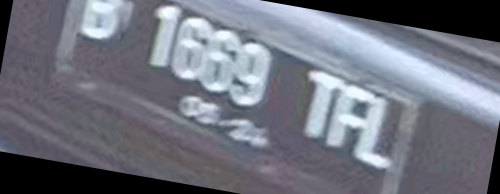

In [ ]:
train_images_data[train_df.iloc[0]['NameofFile']].convert('RGB')

In [ ]:
encoding = train_dataset[0]
for k,v in encoding.items():
  print(k, v.shape)

pixel_values torch.Size([3, 384, 384])
labels torch.Size([9])


In [ ]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

B1669TFL


### Finetune the pretrained model

We'll be using model architecture `VisionEncoderDecoderModel` from huggingface library, which can be used to combine any image Transformer encoder (such as ViT, BEiT) with any text Transformer as decoder (such as BERT, RoBERTa, GPT-2)


We'll also used pretrained weights from `microsoft/trocr-base-stage1`. For more details on how the weights were calculated/collected, you can refer to the page [link](https://huggingface.co/microsoft/trocr-base-stage1)

In [ ]:
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-stage1")
model

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-stage1 and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=False)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fea

--------------------------------------------------------------------------------
Important steps, we need to set a couple of attributes of the model:
* the attributes required for creating the `decoder_input_ids` from the `labels` (the model will automatically create the `decoder_input_ids` by shifting the `labels` one position to the right and prepending the `decoder_start_token_id`, as well as replacing ids which are -100 by the pad_token_id)
* the vocabulary size of the model (for the language modeling head on top of the decoder)
* beam-search related parameters which are used when generating text.

In [ ]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id

# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 9
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 1
model.config.num_beams = 4

In [ ]:
# Set the training arguments, got this values from manual hyperparameters tuning
training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=12,
    per_device_eval_batch_size=12,
    fp16=True,
    output_dir="./",
    logging_steps=20,
    save_steps=1000,
    eval_steps=200,
)

We will evaluate the model on the Character Error Rate (CER). This value indicates the percentage of characters that were incorrectly predicted

The compute_metrics function takes an `EvalPrediction` (which is a NamedTuple) as input, and should return a dictionary. The model will return an EvalPrediction at evaluation, which consists of 2 things:
* predictions: the predictions by the model.
* label_ids: the actual ground-truth labels.

In [ ]:
cer_metric = load_metric("cer")

def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}

In [ ]:
# The default_data_collator provides a method to batch together data automatically
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.feature_extractor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
)
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/models/trocr/processing_trocr.py:135: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


Step,Training Loss,Validation Loss,Cer
200,0.602100,0.476622,0.065999
400,0.381700,0.352366,0.032772
600,0.260100,0.294124,0.020786
800,0.224400,0.260888,0.011379


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1417: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
  warnings.warn(


TrainOutput(global_step=858, training_loss=0.507368474295645, metrics={'train_runtime': 1621.8415, 'train_samples_per_second': 6.348, 'train_steps_per_second': 0.529, 'total_flos': 9.110883560004256e+18, 'train_loss': 0.507368474295645, 'epoch': 3.0})

In [ ]:
predictions = trainer.evaluate(eval_dataset)
predictions['eval_loss']

0.24895377457141876

In [ ]:
# Save the trained model using the trainer
trainer.save_model("/content/drive/MyDrive/TrOCR_LicensePlateIndonesia/finetune_model_trocr")

### Predict Test Images

Note when the model trained on Google Colab GPU notebook, you may find error when tries to directly predict images using the model. It happened because the model is currently in the GPU, while your data are in the CPU.

To fix this, you must make sure the model and datas are in the same environment. One of which you can do is to import the model back using the  `.from_pretrained` method.

In [ ]:
from transformers import VisionEncoderDecoderModel

model = VisionEncoderDecoderModel.from_pretrained("/content/drive/MyDrive/TrOCR_LicensePlateIndonesia/finetune_model_trocr")

#### Testing on 1 of the data

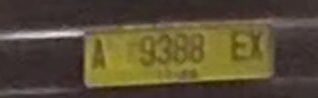

In [ ]:
image = test_images_data[df_test.iloc[1]['NameofFile']].convert('RGB')
image

In [ ]:
encoding = test_dataset[1]
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

A9388EX


In [ ]:
pixel_values = processor(image, return_tensors="pt").pixel_values

generated_ids = model.generate(pixel_values)

generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print('predicted label : {}'.format(generated_text))

predicted label : A9388EX


#### Predict on all test data

In [ ]:
from tqdm import tqdm
predicted_labels = []

iterable = tqdm(df_test.iterrows(), total=len(df_test), desc="Processing", unit="image")
for index, row in iterable:
    # Load and preprocess the image
    image = test_images_data[row['NameofFile']].convert("RGB")
    pixel_values = processor(image, return_tensors="pt").pixel_values

    # Generate predictions
    generated_ids = model.generate(pixel_values)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    predicted_labels.append(generated_text)


Processing: 100%|██████████| 100/100 [23:43<00:00, 14.24s/image]


In [ ]:
from datasets import load_metric

cer_metric = load_metric("cer")

# Calculate the CER score
cer = cer_metric.compute(predictions=predicted_labels, references=df_test['Vehicleregistrationplate'])

print(cer)

0.026281208935611037


### Analys the predictions

In [ ]:
df_test['predicted'] = predicted_labels
df_test

,Vehicleregistrationplate,NameofFile,predicted
0,AD7034OE,DataTest1.png,AD7034QE
1,A9388EX,DataTest2.png,A9388EX
2,B16TB,DataTest3.png,B16TB
3,B1661TKZ,DataTest4.png,B1661TKZ
4,AD3772ABE,DataTest5.png,AD3772ABE
...,...,...,...
95,B1285QL,DataTest96.png,B1285UL
96,AB8644PK,DataTest97.png,AB8644PK
97,AG9718EG,DataTest98.png,AG9718EG
98,B1509UN,DataTest99.png,B1509UN


In [ ]:
# Check the datas where the model got it wrong
df_test_diff = df_test.loc[df_test['Vehicleregistrationplate'] != df_test['predicted']]
df_test_diff = df_test_diff.reset_index()
df_test_diff.drop('index', axis=1, inplace=True)
df_test_diff

,Vehicleregistrationplate,NameofFile,predicted
0,AD7034OE,DataTest1.png,AD7034QE
1,B2271BV,DataTest6.png,B1273VY
2,B13QO,DataTest20.png,B17QO
3,AB6328LZ,DataTest21.png,AB6828Z
4,B8120KXT,DataTest31.png,B0120KXT
5,AB4923UH,DataTest41.png,AB4923QH
6,B202UL,DataTest44.png,B1202UL
7,B1820U,DataTest59.png,B1820QH
8,B1422BKH,DataTest60.png,B1422BK
9,AA7004QF,DataTest68.png,AA7014OF


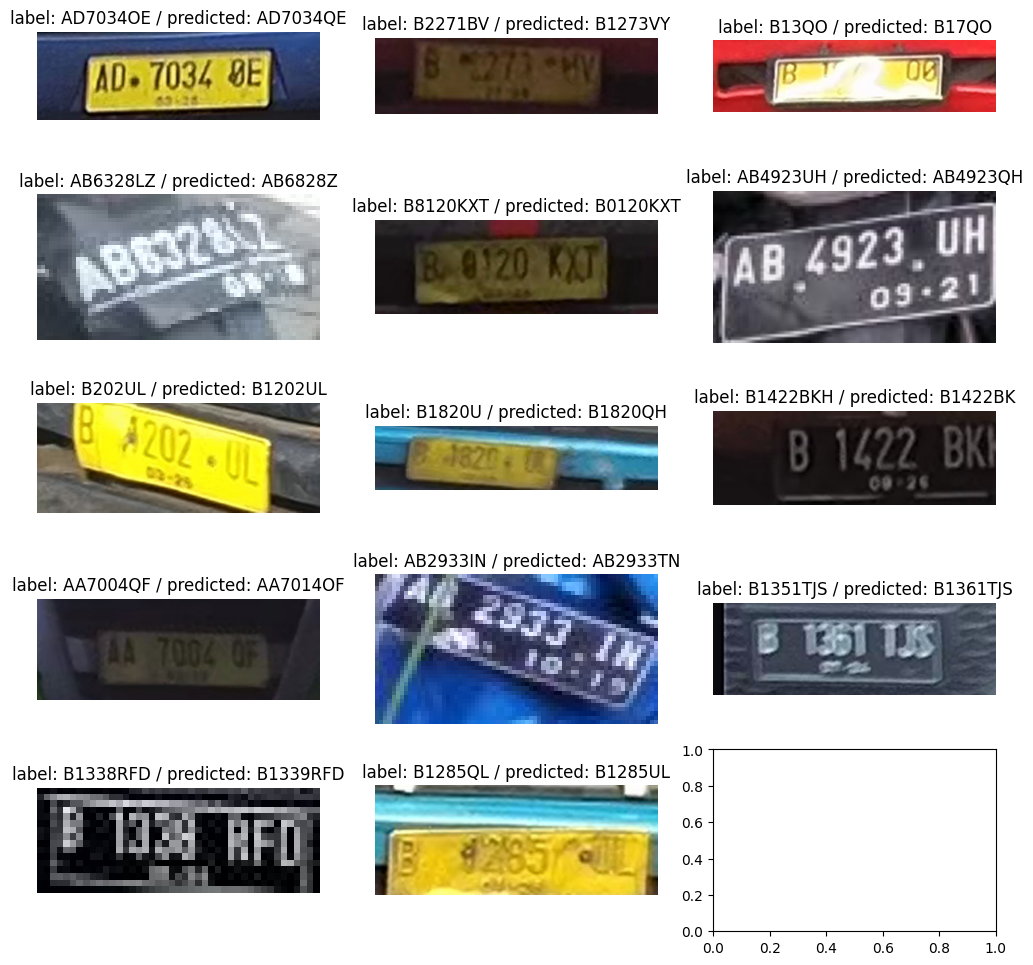

In [ ]:
import matplotlib.pyplot as plt

def display_images(image_list, label1_list, label2_list):
    num_images = len(image_list)
    num_rows = 5
    num_cols = 3

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))
    for i in range(num_rows):
        for j in range(num_cols):
            index = i * num_cols + j
            if index < num_images:
                axes[i, j].imshow(image_list[index])
                axes[i, j].axis('off')
                axes[i, j].set_title(f"label: {label1_list[index]} / predicted: {label2_list[index]}")

    plt.tight_layout()
    plt.show()

problem_image_list = []
for i in df_test_diff['NameofFile']:
    problem_image_list.append(test_images_data[i])

display_images(problem_image_list, df_test_diff['Vehicleregistrationplate'], df_test_diff['predicted'])

The CER metrics are 0.026281208935611037,

So we can say that the model have an accuracy of <b>97.4%</b>